Last Change: 2020/02/06 16:50:44.

auther: tsuyo-pon

# Bandpass(帯域通過フィルタ)
音響解析をする上で，ノイズ除去などのフィルタ処理が必要となるケースは多くあります．

ここでは，Filterの基本になるLow pass filter(低域通過フィルタ)とHigh pass filter(高域通過フィルタ)，それらを併せ持ったBand pass filter(帯域通過フィルタ)を説明します．
- *フィルタ処理自体が，フーリエ変換と逆フーリエ変換の処理を内包しています*

新規の内容はContentsの太字部分です．

序盤は重複する内容があるので，各人の状況に合わせて読み進めてください．
## Contents
1. サイン波の生成(Make a sine wave)
1. サイン波の合成(Make a synthesized sine wave)
1. **低域通過フィルタ(Low pass filter)**
1. **高域通過フィルタ(High pass filter)**
1. **帯域通過フィルタ(Band pass filter)**
1. **合成したサイン波の音声再生(Play a synthesized sine wave)**
1. **変換したサイン波の音声再生(Play a converted sine wave)**

## サイン波の生成(Make a sine wave)
まずは簡単なサイン波を生成しましょう．
サイン波の式は以下の通りです．

$$
s(t) = A\sin(2{\pi}ft) \tag{1}
$$

数式の説明は以下の通りです．
- A: 振幅
- f: 周波数・振動数
- t: 時刻

ただ，時刻tをそのまま扱うのは難しいので，以下の式でサンプル数に変換しましょう．
- *時間は連続値ですが，デジタルで扱うには離散値にしなければなりません*

$$
t=\frac{n}{f_s} \tag{2}
$$

数式の説明は以下の通りです．
- n: サンプル番号
- fs: サンプリング周波数

①式に②を代入することで，サンプルの時点でのサイン波の振幅が計算できます．

$$
s(n)=A \sin\left(\frac{2{\pi}fn}{f_s}\right)
$$

この式をプログラムで再現すれば，サイン波を生成できます．
- *作りたいサイン波に合わせて，振幅や振動数の値を変化させて見よう!*

In [1]:
from numpy import array, arange, sin, pi
a = 0.5     # 振幅
f = 440     # 周波数
fs = 8000   # サンプリング周波数
sec = 1     # サイン波の持続時間
data = array([
    a * sin(2 * pi * f * n / fs)
    for n in arange(sec * fs)
])
print(data.size)  # 一秒分のサイン波を生成しているので当然 fs と同じ数になる

8000


生成されたサイン波を見てみましょう．
dataは8000個もあって大変みづらいので，最初の80個だけ見てみましょう．
- *1秒で8000個のサンプルがあるところを，80個だけ見るので0.01秒ですね!*
- 横軸: 時間
- 縦軸: 振幅

In [2]:
import matplotlib.pyplot as plt

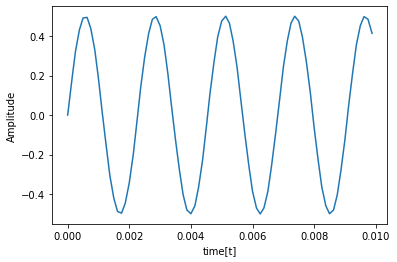

In [3]:
time = [round(i/fs, 5) for i in range(data.size)]
plt.plot(time[0:80], data[0:80])
plt.xlabel("time[t]")
plt.ylabel("Amplitude")
plt.show()

よく見るサイン波が描けましたね!

In [4]:
# 以下お遊び
import IPython.display
from ipywidgets import interact

@interact(f=440, sec=1)
def func(f, sec):
    a = 5
    fs = 8000   # サンプリング周波数
    data = array([
        a * sin(2 * pi * f * n / fs)
        for n in arange(sec * fs)
    ])
    return IPython.display.Audio(data, rate=fs)

interactive(children=(IntSlider(value=440, description='f', max=1320, min=-440), IntSlider(value=1, descriptio…

## サイン波の合成(Make a synthesized sine wave)
先ほど適当な振幅やら周波数やらでサイン波を生成しました．

次は，いろんなサイン波を作って混ぜてみましょう!

In [5]:
a = 0.5                   # 振幅
f_list = [262, 330, 392]  # まぜる周波数
# f_list = [700, 800]  # まぜる周波数
fs = 8000                 # サンプリング周波数
sec = 1                   # サイン波の持続時間

amp = float(a) / len(f_list) # まぜる時の振幅
data = []
for n in arange(sec * fs):
    s = 0.0
    for f in f_list:
        s += amp * sin(2 * pi * f * n / fs)
    data.append(s)
data = array(data)

合成されたサイン波を見てみましょう．

これまたdataは8000個もあって大変みづらいので，最初の80個だけ見てみましょう．
- *サンプリング周波数fsも持続時間secも変化させなければ，横軸timeも変わりません*
- 横軸: 時間
- 縦軸: 振幅

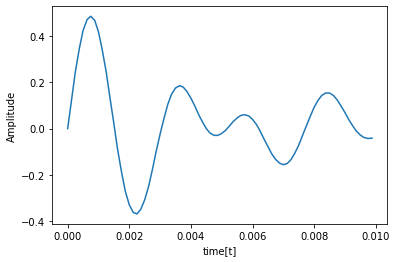

In [6]:
time = [round(i/fs, 5) for i in range(data.size)]
plt.plot(time[0:80], data[0:80])
# plt.plot(time[0:400], data[0:400])
plt.xlabel("time[t]")
plt.ylabel("Amplitude")
plt.show()

単調なサイン波より複雑な波形が確認できました!

## 低域通過フィルタ(Low pass filter)
まず低域通過フィルタについて．

低域通過フィルタとは，ある周波数より上の帯域を減衰させるフィルタです．
- *ノイズ除去などでよく使われます*

フィルターは何度か使うので関数化しておきます．

In [7]:
def lowpass_filter(wav_data, cutoff_lowpass, fs):
    """帯域通過フィルター
    入力:
        numpy.ndarray型, 音声波形データ
        int型, カットオフ周波数_ローパス
        int型, サンプリング周波数
    出力:
        numpy.ndarray型, フィルタ後の音声波形データ
    """
    import numpy as np
    from scipy import signal

    filter = signal.firwin(
        numtaps=20, cutoff=cutoff_lowpass, fs=fs, window="hanning"
    )
    filter_data = signal.lfilter(filter, 1, wav_data)
    return filter_data

フィルタ前波形は以下のような合成波を考えます．

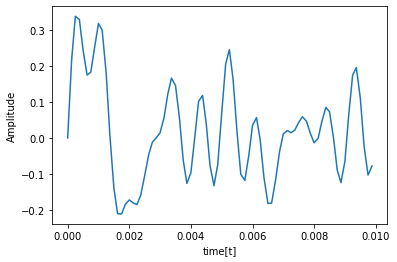

In [8]:
a = 0.5                        # 振幅
f_list = [262, 330, 392, 440, 1000, 1200]  # まぜる周波数
fs = 8000                      # サンプリング周波数
sec = 1                        # サイン波の持続時間

amp = float(a) / len(f_list) # まぜる時の振幅
data = []
for n in arange(sec * fs):
    s = 0.0
    for f in f_list:
        s += amp * sin(2 * pi * f * n / fs)
    data.append(s)
data = array(data)

time = [round(i/fs, 5) for i in range(data.size)]
plt.plot(time[0:80], data[0:80])
plt.xlabel("time[t]")
plt.ylabel("Amplitude")
plt.show()

スペクトルは以下のようになっています．

In [9]:
from numpy import abs
from scipy import fftpack

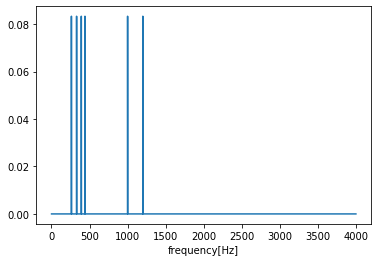

In [10]:
yf = fftpack.fft(data)/(len(data)/2)
freq = fftpack.fftfreq(len(data), fs)
plt.plot(
    array(range(1, int(len(data)/2))),
    abs(yf[1: int(len(data)/2)])
)
plt.xlabel("frequency[Hz]")
plt.show()

この合成波を帯域通過フィルタにかけます．
- 引数は以下の順番
    - 音声波形データ
    - 低域通過フィルタ
    - サンプリング周波数

In [11]:
filtered_data = lowpass_filter(data, 500, fs)

音声波形は以下のようになります．

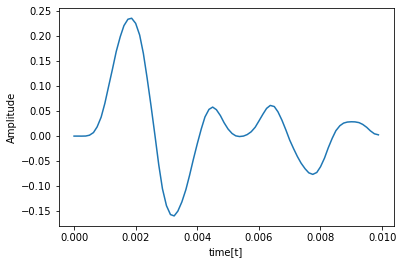

In [12]:
time = [round(i/fs, 5) for i in range(filtered_data.size)]
plt.plot(time[0:80], filtered_data[0:80])
plt.xlabel("time[t]")
plt.ylabel("Amplitude")
plt.show()

ギザギザが減って，序盤に作った波形に近づいたと思います．

スペクトルの方は以下のようになります．

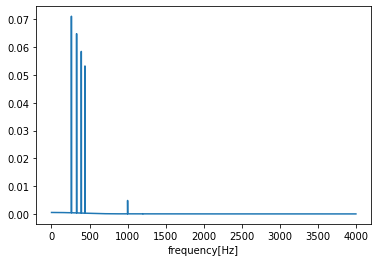

In [13]:
yf = fftpack.fft(filtered_data)/(len(filtered_data)/2)
freq = fftpack.fftfreq(len(filtered_data), fs)
plt.plot(
    array(range(1, int(len(filtered_data)/2))),
    abs(yf[1: int(len(filtered_data)/2)])
)
plt.xlabel("frequency[Hz]")
plt.show()

お分りいただけただろうか．

500Hz以上の周波数は減衰しているが，それにつられて500Hz以下の周波数も減衰しているのである．

フィルターは一般的に通過帯域に対しても多少の減衰がおきます．
- *ハイレゾを聞いた際に音の違いに気がつけるのは，フィルターの反動が知覚できる周波数帯まで影響を与えている可能性微レ存*

## 高域通過フィルタ(High pass filter)

## 帯域通過フィルタ(Band pass filter)
最後に帯域通過フィルタについて．

帯域通過フィルタとは，ある周波数より下の周波数帯域を減衰し，また別の周波数より上の帯域を減衰させるフィルタです．
- *ぶっちゃけ低域通過フィルタと高域通過フィルタの合わせ技*

フィルターは何度か使うので関数化しておきます．

In [14]:
def bandpass_filter(wav_data, cutoff_highpass, cutoff_lowpass, fs):
    """帯域通過フィルター
    入力:
        numpy.ndarray型, 音声波形データ
        int型, カットオフ周波数_ハイパス
        int型, カットオフ周波数_ローパス
        int型, サンプリング周波数
    出力:
        numpy.ndarray型, フィルタ後の音声波形データ
    """
    import numpy as np
    from scipy import signal

    filter = signal.firwin(
        numtaps=20, cutoff=[cutoff_highpass, cutoff_lowpass], fs=fs, window="hanning", pass_zero=False
        # ↓超強力なフィルタ
        # numtaps=2000, cutoff=[cutoff_highpass, cutoff_lowpass], fs=fs, window="hanning", pass_zero=False
    )
    filter_data = signal.lfilter(filter, 1, wav_data)
    return filter_data

フィルタ前波形は以下のような合成波を考えます．
- *高周波数が混ざっているからギザギザ*

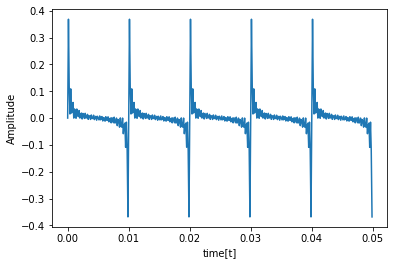

In [15]:
a = 0.5                        # 振幅
f_list = range(100, 3000, 100)    # まぜる周波数
fs = 8000                      # サンプリング周波数
sec = 1                        # サイン波の持続時間

amp = float(a) / len(f_list) # まぜる時の振幅
data = []
for n in arange(sec * fs):
    s = 0.0
    for f in f_list:
        s += amp * sin(2 * pi * f * n / fs)
    data.append(s)
data = array(data)

time = [round(i/fs, 5) for i in range(data.size)]
plt.plot(time[0:400], data[0:400])
plt.xlabel("time[t]")
plt.ylabel("Amplitude")
plt.show()

スペクトルは以下のようになっています．

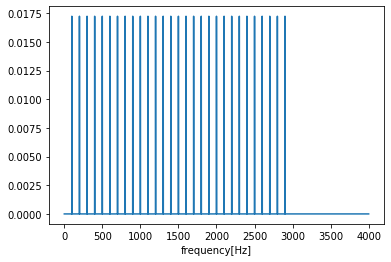

In [16]:
yf = fftpack.fft(data)/(len(data)/2)
freq = fftpack.fftfreq(len(data), fs)
plt.plot(
    array(range(1, int(len(data)/2))),
    abs(yf[1: int(len(data)/2)])
)
plt.xlabel("frequency[Hz]")
plt.show()

この合成波を帯域通過フィルタにかけます．
- 引数は以下の順番
    - 音声波形データ
    - 高域通過フィルタ
    - 低域通過フィルタ
    - サンプリング周波数

In [17]:
filtered_data = bandpass_filter(data, 700, 800, fs)

音声波形は以下のようになります．

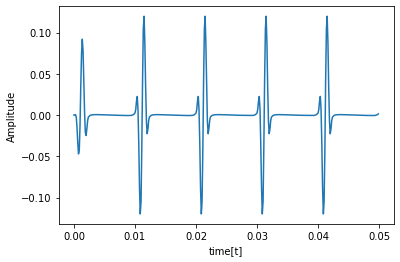

In [18]:
time = [round(i/fs, 5) for i in range(filtered_data.size)]
plt.plot(time[0:400], filtered_data[0:400])
plt.xlabel("time[t]")
plt.ylabel("Amplitude")
plt.show()

ギザギザが減って，序盤に作った波形に近づいたと思います．

スペクトルの方は以下のようになります．

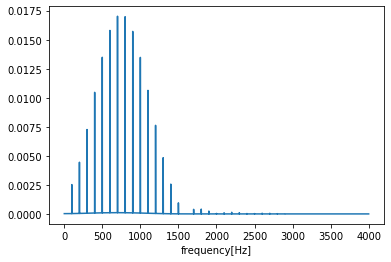

In [19]:
yf = fftpack.fft(filtered_data)/(len(filtered_data)/2)
freq = fftpack.fftfreq(len(filtered_data), fs)
plt.plot(
    array(range(1, int(len(filtered_data)/2))),
    abs(yf[1: int(len(filtered_data)/2)])
)
plt.xlabel("frequency[Hz]")
plt.show()

フィルタ強度を強くしない場合は，完全に減衰させられるとは限らない．
- *フィルタ強度は強くすれば強くするほど良いというわけではない．*

## 合成したサイン波の音声再生(Play a synthesized sine wave)
合成したサイン波を一度聞いて置きましょう．

聞くためにまず音声ファイルとして保存をします．

In [20]:
import soundfile as sf

# パスは各自の環境に合わせてください．
sf.write('../wav/synthesized.wav', data, fs)

保存されたら，別のターミナルを開いて以下のコマンドで再生してください．
- *再生できない人は大人しくPraatで聞いてください*

```
play synthesized.wav
```

In [21]:
import IPython.display

IPython.display.Audio(data, rate=fs)

## 変換したサイン波の音声再生(Play a converted sine wave)
続いてフィルター処理した波形を聞いてみましょう．

聞くためにこちらも音声ファイルとして保存します．

In [22]:
# パスは各自の環境に合わせてください．
sf.write('../wav/filtered.wav', filtered_data, fs)

保存されたら，別のターミナルを開いて以下のコマンドで再生してください．
- *再生できない人は大人しくPraatで聞いてください*

```
play filtered.wav
```

In [23]:
import IPython.display

IPython.display.Audio(filtered_data, rate=fs)

変換前の音とは違うことが聞いて撮れると思います．

## 補足-音声の読み込み(read wav)
ちなみに音声ファイルは以下のコマンドで読み込むことができます．

In [24]:
data, fs = sf.read('../wav/filtered.wav')

[Back](ifft.ipynb)
/
[Home](../)